# Abalone Age Prediction: Classification or Regression Task? Improving Model Performance

Author: **Marcin Sikorski**<br>
Date: May, 2022

The age of an abalone (or sea snail) can be estimated by cutting its shell, staining it, and counting the number of rings in the shell through a microscope. However, this process is time-consuming, boring, and can cause death to the creature. Therefore, it is necessary to find another non-collision method for age estimation. Other physical measurements, which are easier to collect, can be used to determine the age.

**Problem Statement**<br>
The objective is to analyze and build a predictive model that will find the ages of abalones from physical measurements. We will search for possible ways to improve their efficiencies. This would enable researchers to estimate the age without the need of cutting its shell for ring counting.<br>
In this notebook we will develop models to map from input variables to output variables, and see how well we are able to estimate the number of rings in abalone shells. We will provide and implement supervised machine-learning algorithms to predict output variables from high-dimensional observations. The target data, <code>rings</code>, contains numeric data (regression) which can also pose as labels (classification). We will verify if indeed this dataset is associated with these tasks. The number of rings is the value to predict: either as a continuous value or as a classification label.

**Table of Contents:**
1. Loading Libraries and Dataset
2. Exploratory Data Analysis<br>
    2a. Correcting Measurement Errors<br>
    2b. Searching for any Statistical Relationships<br>
    2c. Feature Distribution
3. Normalizing and Splitting Data
4. Regression Model
5. Tuning and Optimizing the Regressor<br>
    5a. Finding the Best Order of Polynomial<br>
    5b. Ridge Regression (L2 Regularization)<br>
    5c. LASSO Regression (L1 Regularization)
6. Classification Model
7. Tuning and Optimizing the Classifier<br>
    7a. Finding the Best Number of Neighbors
8. Summary

### 1. Loading Libraries and Dataset

We will download data directly from UCI Machine Learning Repository website (https://archive.ics.uci.edu/ml/datasets/Abalone). Data comes from an original (non-machine-learning), Australian study from 1994. There are no column labels in the dataset, so we will copy them from the documentation and paste in the script. There is also a note that adding 1.5 to rings gives the age in years. We will perform our tasks without this constant and not apply this rule because a classifier will not work on decimals.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

# import data and create dataframe
def load_dataset():
    url = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
    abalone = pd.read_csv(url, header=None)
    
    # labels
    abalone.columns = ['sex', 'length', 'diameter', 'height', 'whole weight',
                       'shucked weight', 'viscera weight', 'shell weight', 'rings']
    #abalone['age'] = abalone['rings'] + 1.5
    #abalone = abalone.drop('rings', axis=1)
    return abalone

abalone = load_dataset()
abalone.head()

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


### 2. Exploratory Data Analysis

We successfully loaded the sample into the repository. It is time to investigate the data to summarize the dataset, get a good understanding, and see what the data can tell us before the modeling task. We will also search for possible mistakes, feature distribution, and patterns. We also want to get other information like: completness and size.

In [2]:
# instances and features
abalone.shape

(4177, 9)

In [3]:
# concise summary of dataset
abalone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   sex             4177 non-null   object 
 1   length          4177 non-null   float64
 2   diameter        4177 non-null   float64
 3   height          4177 non-null   float64
 4   whole weight    4177 non-null   float64
 5   shucked weight  4177 non-null   float64
 6   viscera weight  4177 non-null   float64
 7   shell weight    4177 non-null   float64
 8   rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 277.4+ KB


In [4]:
# unique values in 'sex' column
abalone['sex'].unique()

array(['M', 'F', 'I'], dtype=object)

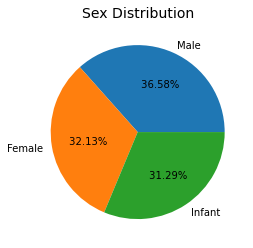

In [5]:
# plot sex distribution
def plot_pie_chart():
    values = abalone['sex'].value_counts()
    labels = ['Male', 'Female', 'Infant']
    plt.pie(values, labels=labels, autopct=lambda p: f'{p: .2f}%')
    plt.title('Sex Distribution', size=14)
    plt.show()
    
plot_pie_chart()

All given features are float except for <code>sex</code> column, which contains labels. We can find out from the summary that there are no missing values in our data.

#### 2a. Correcting Measurement Errors

In [6]:
# descriptive statistics of dataset
abalone.describe()

,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
count,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000,4177.000000
mean,0.523992,0.407881,0.139516,0.828742,0.359367,0.180594,0.238831,9.933684
std,0.120093,0.099240,0.041827,0.490389,0.221963,0.109614,0.139203,3.224169
min,0.075000,0.055000,0.000000,0.002000,0.001000,0.000500,0.001500,1.000000
25%,0.450000,0.350000,0.115000,0.441500,0.186000,0.093500,0.130000,8.000000
50%,0.545000,0.425000,0.140000,0.799500,0.336000,0.171000,0.234000,9.000000
75%,0.615000,0.480000,0.165000,1.153000,0.502000,0.253000,0.329000,11.000000
max,0.815000,0.650000,1.130000,2.825500,1.488000,0.760000,1.005000,29.000000


Again, the first row in the description suggests no missing values in the data. However, if we look carefully, there is a value of 0.0 in the <code>height</code> column (min value). This is most likely a measurement error in the data and we have to adjust it first. Dropping rows is not also the best approach because we can lose lots of information. We can update this value with a mean.

In [7]:
# instances with 0 value
abalone.loc[abalone['height'] == 0]

,sex,length,diameter,height,whole weight,shucked weight,viscera weight,shell weight,rings
1257,I,0.430,0.34,0.0,0.428,0.2065,0.0860,0.1150,8
3996,I,0.315,0.23,0.0,0.134,0.0575,0.0285,0.3505,6


In [8]:
# average heights for each gender
def pivot_table():
    pt = pd.pivot_table(data=abalone, index='sex', aggfunc={'height': np.mean})
    return np.round(pt, 3).T

pivot_table()

sex,F,I,M
height,0.158,0.108,0.151


In [9]:
# update values in rows
def update_values():
    abalone.at[1257, 'height'] = 0.108
    abalone.at[3996, 'height'] = 0.108
    
update_values()

Fortunately, the rows were not numerous and concerned to one sex class. Using a pivot table we aggregated <code>height</code> with mean values for each of the three labels. We replaced the incorrect height values. 

#### 2b. Searching for any Statistical Relationships

We will check if we can discover any possible patterns in the data.

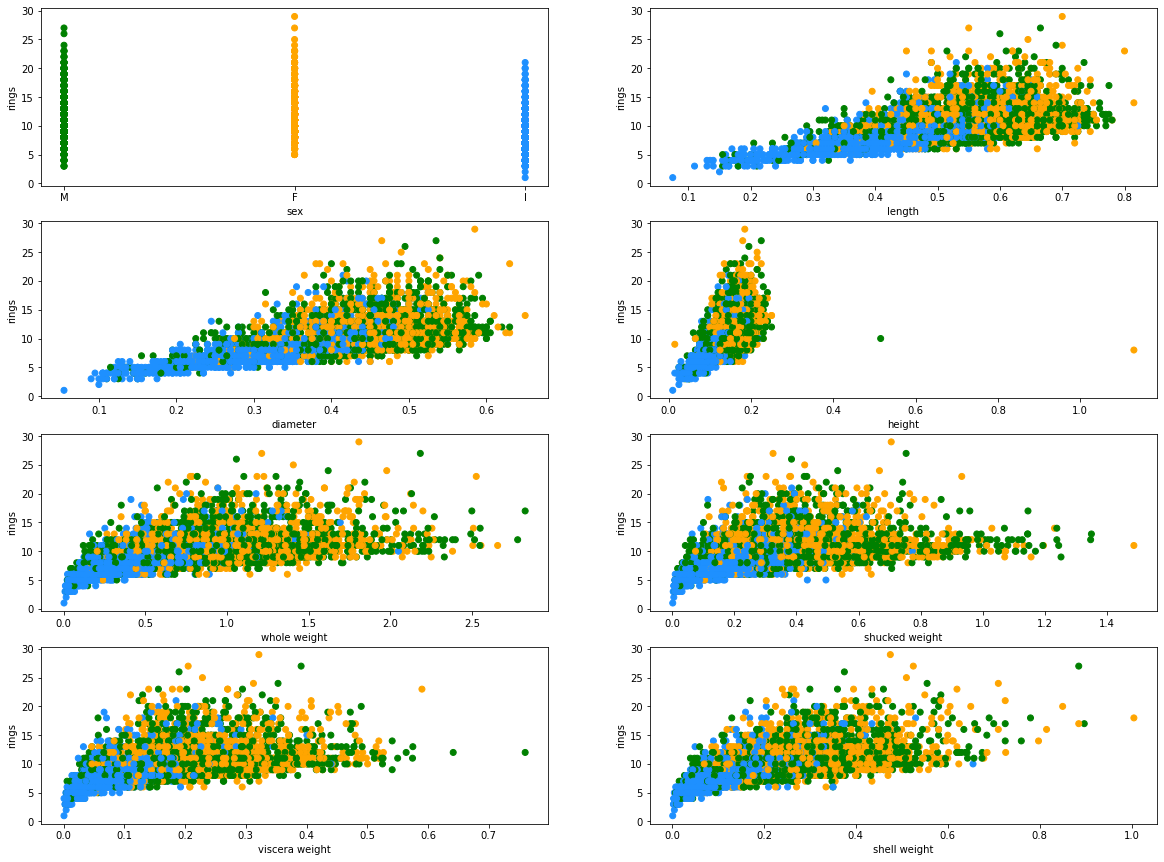

In [10]:
# plot scatter plots
def plot_scatter_plots():
    i, j = 0, 0
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
    # map colors by sex classes
    colors = {'F': 'orange', 'I': 'dodgerblue', 'M': 'green'}
    
    # without last column ('age')
    for column in abalone.iloc[:, 0:-1]:
        ax[i][j].scatter(x=abalone[column], y=abalone['rings'], c=abalone['sex'].map(colors))
        ax[i][j].set_xlabel(column)
        ax[i][j].set_ylabel('rings')
        j += 1
        if j % 2 == 0:
            i += 1
            j = 0
    plt.show()
    
plot_scatter_plots()

There certainly are correlations between physical features and abalone rings. The relationships are not strong but developing a regression model is still possible. Additionally, we can drop <code>sex</code> column. It is a categorical data type and does not bring in much value. We can spot that infant marine slugs indeed tend to have smaller measurements, but males and females do not differ much. There are also possible outliers in the remaining attributes. 

We will display a heatmap with Pearson correlations between attributes (espacially numerical features with target data).

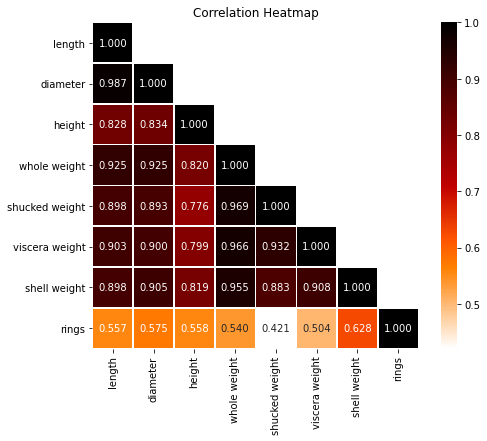

In [11]:
from seaborn import heatmap

# plot heatmap
def plot_heatmap():
    # define correlation matrix
    corr_df = abalone.corr(method='pearson')
    df_lt = corr_df.where(np.tril(np.ones(corr_df.shape)).astype(np.bool))
    
    # plot heatmap
    plt.figure(figsize=(8, 6))
    heatmap(df_lt, annot=True, square=True, cbar=True, linewidths=.5, fmt='.3f', cmap='gist_heat_r')
    plt.title('Correlation Heatmap')
    plt.show()

plot_heatmap()

The last row displays each numerical characteristics linear correlation with the target data. As observed previously on scatter plots, the linearity to the target vector is moderate with an average value 0.5 (neither strong nor weak). For our future regression models we will not concern the <code>shucked weight</code> feature.

#### 2c. Feature Distribution

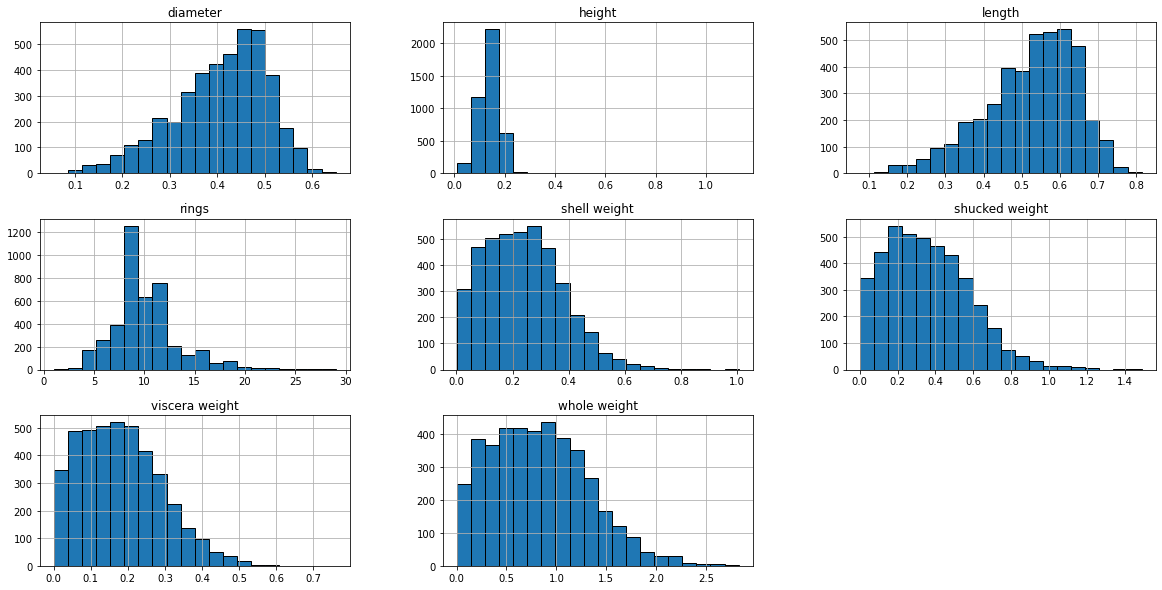

In [12]:
# variable distribution
abalone.hist(figsize=(20, 10), bins=20, edgecolor='black')
plt.show()

Most of our attributes do not have Gaussian distribution, except for <code>height</code> which looks normally distributed. The <code>diameter</code> and <code>length</code> characteristics have values that are slightly distributed to the right of the curve - this is negative skewness. The other attributes have a value distribution that is on the left of the curve, which means the skewness is positive. Since we are mostly interested in target vector (<code>rings</code> column), we can aggregate and count each unique value.

In [13]:
# count rings
abalone[['rings', 'diameter']].groupby('rings').count()

,diameter
rings,
1,1
2,1
3,15
4,57
5,115
6,259
7,391
8,568
9,689


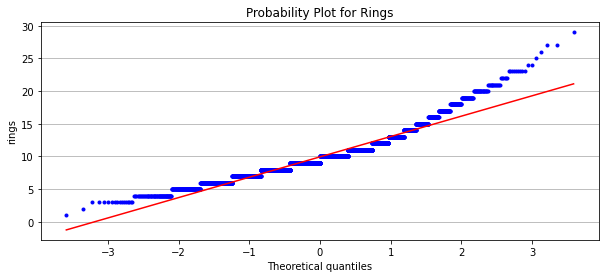

In [14]:
from scipy.stats import probplot

# probability plot
def probability_plot():
    fig = plt.figure(figsize=(10, 4))
    ax = plt.subplot(1, 1, 1)
    probplot(abalone['rings'].values, dist='norm', plot=ax)
    ax.get_lines()[0].set_markersize(3)
    plt.title('Probability Plot for Rings')
    plt.ylabel('rings')
    plt.grid(axis='y')
    plt.show()
    
probability_plot()

The probability plot is a graphical technique for assessing whether or not a dataset follows a given distribution (in our case Gaussian). All the markers should form approximately a straight line (on red line). Any significant deviations indicate the distribution is skewed. This graph displays more positive skewness.

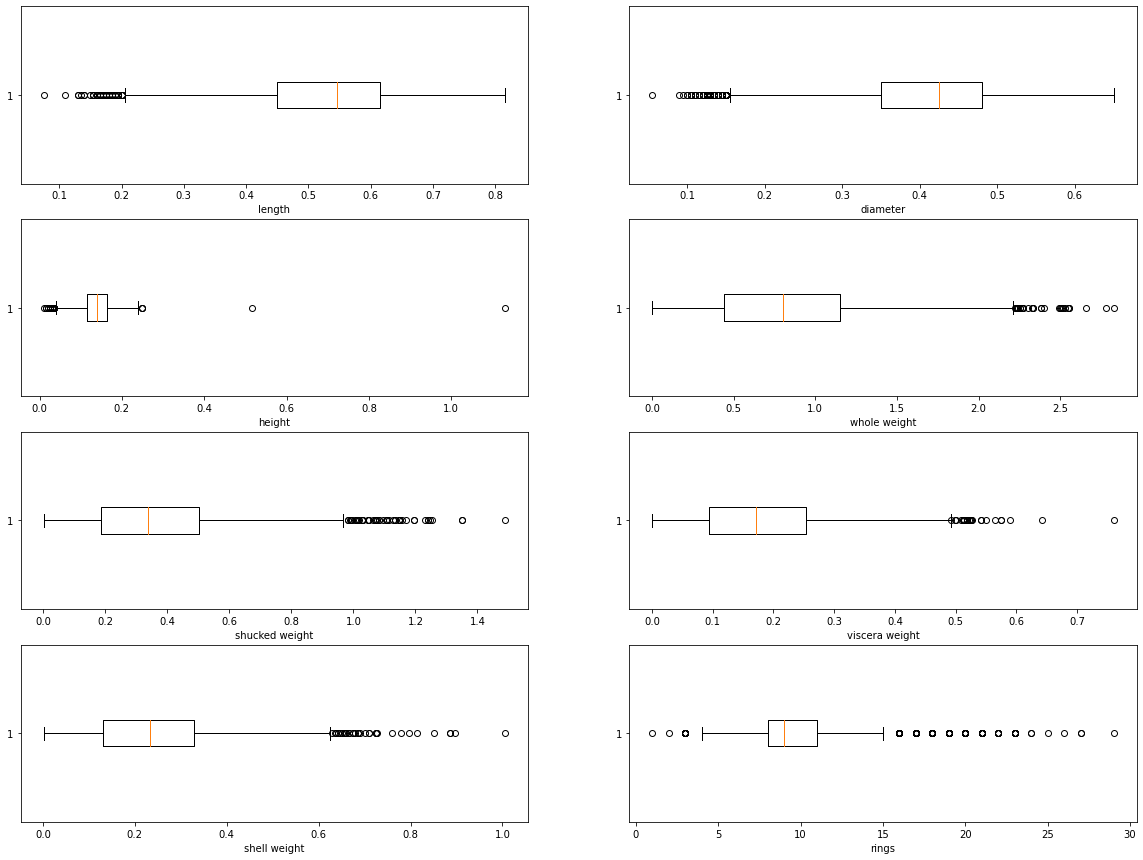

In [15]:
# plot box plots
def plot_box_plots():
    i, j = 0, 0
    fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(20, 15))
    
    # without first column ('sex')
    for column in abalone.iloc[:, 1:]:
        ax[i][j].boxplot(x=abalone[column], vert=False)
        ax[i][j].set_xlabel(column)
        j += 1
        if j % 2 == 0:
            i += 1
            j = 0
    plt.show()
    
plot_box_plots()

Each continuous attribute in this dataset has possible outliers. These errors might possibly cause the data to not be normally distributed. This time we will skip removing the outliers. Detecting outliers is not the main topic of this analysis and we do not want to lose important data. There are too much observations to interpolate or replace with average values.

###  3. Normalizing and Splitting Data

It is a good practice to scale or standardize the characteristics for machine learning tasks. These actions can also improve further prediction accuracy. We will normalize our variables. Normalization typically means rescaling the values into a range of [0, 1].

Next, we will split our dataset into training and validation sets and accept a 70:30 ratio. This split was chosen arbitrarily.

For our $X$ feature array we will drop these columns:
* <code>age</code> - target vector, the data we want to predict;
* <code>sex</code> - categorical data, not very useful and <code>NumPy</code> arrays must contain the same data type;
* <code>shucked weight</code> - low correlation with target data, not much useful.

In [16]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# normalize and split data
def normalize_split_data():
    # features for X array
    features = abalone.drop(['rings', 'shucked weight', 'sex'], axis=1)
    
    # rescale data
    sc = MinMaxScaler()
    sc.fit(features)
    scaled_features = sc.transform(features)
    
    global X, y, X_train, X_test, y_train, y_test
    # feature array X
    X = scaled_features
    # target data y
    y = abalone['rings']
    
    # split data
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, test_size=0.25, shuffle=True, random_state=3)
    
    print('Train Data:', np.size(X_train, 0), '\nTest Data:', np.size(X_test, 0))

normalize_split_data()

Train Data: 3132 
Test Data: 1045


### 4. Regression Model

We examined on previous scatter plots that the dependences between the predictors and the response are slightly non-linear. A second order polynomial function might be the best fit for creating ring predictions. Modeling data with a polynomial regression model is a good first step because it is one of the simplest models. Once we develop the model, we can determine how good a job it does, and whether we need a more advanced or sophisticated model.

Polynomial regression is a statistical technique to predict a continuous variable (response variable). It is a special case of linear regression where we fit a polynomial equation on the data with a curvilinear relationship between the target variable and the independent variables.

#### Quadratic Polynomial Regression (2nd Degree)

In [17]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

# perform polynomial regression
def polynomial_regression(degree: int):
    if degree < 2:
        raise ValueError('Degree must be greater or equal 2')
        
    # fit model
    # include_bias should be False because we’ll use PolynomialFeatures together with LinearRegression
    poly_reg = Pipeline(steps=[('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                               ('lin', LinearRegression())])
    poly_reg.fit(X_train, y_train)
    
    global reg_pred
    # predict rings
    reg_pred = poly_reg.predict(X_test)
    
    # number of features
    print('Number of Fitted Predictors:', poly_reg.n_features_in_)
    # coefficient b0
    print('Intercept:', poly_reg.named_steps['lin'].intercept_)
    # number of coefficients
    print('Number of Coefficients:', poly_reg.named_steps['lin'].coef_.size)
    # coefficients b1
    print('Coefficients:\n', poly_reg.named_steps['lin'].coef_)
    # return features
    print('Features in Function:\n', poly_reg.named_steps['poly'].get_feature_names_out())
      
polynomial_regression(degree=2)

Number of Fitted Predictors: 6
Intercept: 1.4456517611647044
Number of Coefficients: 27
Coefficients:
 [-1.01161068e+01  2.80851587e+01  2.34676278e+01 -3.74609261e+01
  2.88694393e+01  3.49248350e+01  8.27758621e+00  1.50321183e+01
 -1.46442881e+02  1.18177614e+02 -1.13098271e+02 -5.29218467e+01
 -5.91617905e+01  1.83823592e+02 -7.81275062e+01  9.40187372e+01
  6.44817053e+01 -2.74248890e+01  5.62168546e+01 -1.80529525e+02
  3.76368556e+01 -1.04781140e-01 -6.02660790e+00 -1.77897713e+01
  3.24576548e+01 -2.70660584e+01 -4.27788393e+00]
Features in Function:
 ['x0' 'x1' 'x2' 'x3' 'x4' 'x5' 'x0^2' 'x0 x1' 'x0 x2' 'x0 x3' 'x0 x4'
 'x0 x5' 'x1^2' 'x1 x2' 'x1 x3' 'x1 x4' 'x1 x5' 'x2^2' 'x2 x3' 'x2 x4'
 'x2 x5' 'x3^2' 'x3 x4' 'x3 x5' 'x4^2' 'x4 x5' 'x5^2']


The equation for this polynomial function is complex. To understand how it is built, we can write down the regression formula as following:

$$y = -10.1161 \centerdot x_0 + 28.0852 \centerdot x_1 + 23.4676 \centerdot x_2 + ...+ 32.4576 \centerdot x_4^2 - 27.0660 \centerdot x_4 x_5 - 4.2779 \centerdot x_5^2,$$

where $y$ is the predicted number of rings and $x_0$, $x_1$, $x_2$, $x_3$, $x_4$, $x_5$ are the independent variables.

Lets look up some basic regression metrics and compute residuals.

In [18]:
from sklearn.metrics import r2_score
from sklearn.metrics import max_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

# evaluate performance
def polynomial_regression_metrics():
    # coefficient of determination (or R^2 testing)
    print('R2 Testing Score:', r2_score(y_test, reg_pred))
    # L2 residual
    print('L2 Norm:', np.sqrt(abalone['rings'].var()))
    # maximum error
    print('Maximum Error:', max_error(y_test, reg_pred))
    # root mean squared error
    print('RMSE:', mean_squared_error(y_test, reg_pred, squared=False))
    # mean absolute error
    print('MAE:', mean_absolute_error(y_test, reg_pred))
    
polynomial_regression_metrics()

R2 Testing Score: 0.4594488950961675
L2 Norm: 3.2241690320681284
Maximum Error: 10.851525783604728
RMSE: 2.245661524098418
MAE: 1.629204324797592


This is not an impressive model. By looking at the coefficient of determination we can interpret that the model is going to be almost 46% correct of all predictions, which is moderate. The applicability could be badly affected by the presence of outliers in the predictors (data columns).

Lets visualize the residuals and compare predicted results with real values.

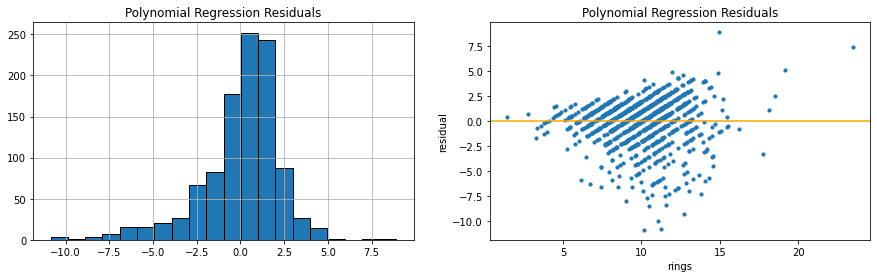

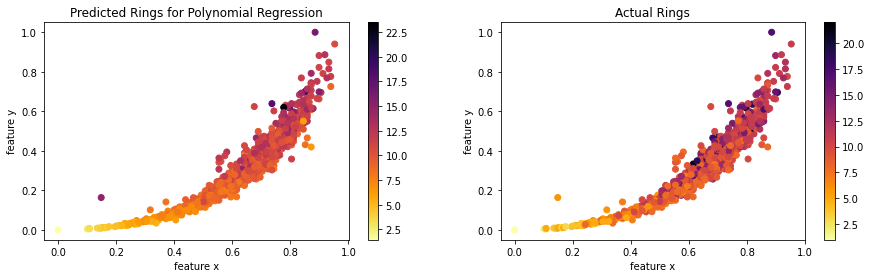

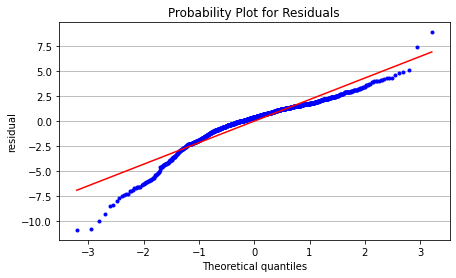

In [19]:
# residual plots
def plot_residuals(pred_val: np.array, title: str):
    fig = plt.figure(figsize=(15, 4))
    
    # row_1
    # subplot_1
    plt.subplot(1, 2, 1)
    residuals = pred_val - y_test
    residuals.hist(bins=20, edgecolor='black')
    plt.title('{} Residuals'.format(title))
    
    # subplot_2
    plt.subplot(1, 2, 2)
    plt.scatter(x=pred_val, y=residuals, s=10, label='test data')
    plt.axhline(y=0, color='orange', linestyle='-')
    plt.title('{} Residuals'.format(title))
    plt.xlabel('rings')
    plt.ylabel('residual')
    plt.show()
    
    plt.figure(figsize=(15, 4))
    cmap='inferno_r'
    
    # row_2
    # subplot_3
    plt.subplot(1, 2, 1)
    plt.scatter(x=X_test[:, 0], y=X_test[:, 3], c=pred_val, cmap=cmap)
    plt.title('Predicted Rings for {}'.format(title))
    plt.xlabel('feature x')
    plt.ylabel('feature y')
    plt.colorbar()
    
    # subplot_4
    plt.subplot(1, 2, 2)
    plt.scatter(x=X_test[:, 0], y=X_test[:, 3], c=y_test, cmap=cmap)
    plt.title('Actual Rings')
    plt.xlabel('feature x')
    plt.ylabel('feature y')
    plt.colorbar()
    plt.show()
        
    # row_3
    # subplot_5
    plt.figure(figsize=(7, 4))
    ax = plt.subplot(1, 1, 1)
    probplot(residuals.values, dist='norm', plot=ax)
    ax.get_lines()[0].set_markersize(3)
    plt.title('Probability Plot for Residuals')
    plt.ylabel('residual')
    plt.grid(axis='y')
    plt.show()  
    
plot_residuals(pred_val=reg_pred, title='Polynomial Regression')

The histogram with residuals shows that 0.0 frequency is not very common (if any). The largest residuals have values upon 11, which is a tremendous error for creatures that live a few decades.

Both the histogram and probability plot present the residual distribution is more negatively skewed. The observations are not normally distributed.

The markers on scatter plots have slightly different colors. The scales on color bars are different - predicted rings display a wider range.

### 5. Tuning and Optimizing the Regressor

The objective of linear regression is to find and fit the best possible function to input data points. A data scientist does not want the prediction model to be underfitted or overfitted. Underfitting condition makes the model not accurate enough, and overfitting begins to describe the random error in the data rather than reflecting the overall population. We use bias and variance terms to describe the fit.

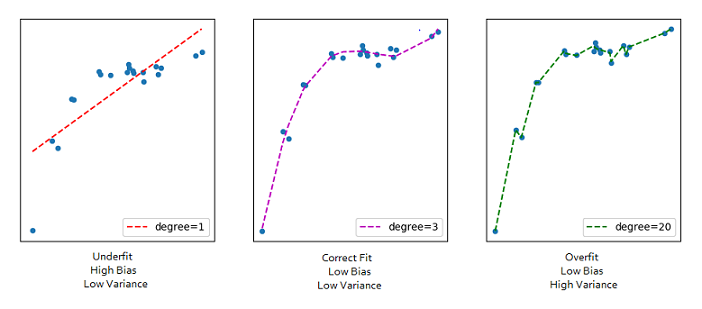

Bias refers to the inability for a machine learning model (in this case linear regression) to capture the true relationship. It is not the intercept but the extent to which model fails. A high bias means that the model is unable to capture the patterns in the data and this results in underfitting. Bias is simply the difference between predicted values and expected results.

Variance refers to the error due to the complex model trying to fit the data. High variance means the model passes through most of the data points and it results in overfitting the data. Variance is the difference between the prediction of all the models obtained from the sample with the average model. It means that there is a difference in fit (or variability) between training data points and validation dataset.

#### 5a. Finding the Best Order of Polynomial

For better predictions in regression problems, we need to choose the optimal degree of freedom for our polynomial function. We can find the best possible degree by calculating mean squared error of validation set for each order.

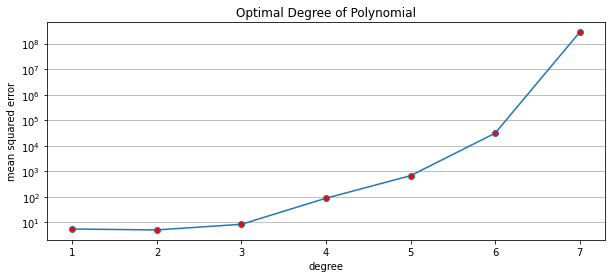

Best Model Fit is For Degree: 2
MSE for Each Order:
 [5.459619670272209, 5.04299568081603, 8.393493916415323, 88.4191448753934, 673.8267346845612, 31222.752271096844, 282178615.73987585]


In [20]:
# find optimal degree of freedom
def optimal_degree():
    # list of mean squared errors
    testing_error = []
    
    # calculate error for degrees between 1 and 8
    for i in range(1, 8):
        poly_reg = Pipeline(steps=[('poly', PolynomialFeatures(degree=i, include_bias=False)),
                                   ('lin', LinearRegression())])
        poly_reg.fit(X_train, y_train)
        reg_pred = poly_reg.predict(X_test)
        # testing errors
        testing_error.append(mean_squared_error(y_test, reg_pred, squared=True))
    
    # visualize results
    plt.figure(figsize=(10, 4))
    plt.plot(range(1, 8), testing_error, marker='o', markerfacecolor='red', markersize=6)
    plt.title('Optimal Degree of Polynomial')
    plt.xlabel('degree')
    plt.yscale('symlog')
    plt.ylabel('mean squared error')
    plt.grid(axis='y')
    plt.show()

    print('Best Model Fit is For Degree:', testing_error.index(min(testing_error)) + 1)
    print('MSE for Each Order:\n', testing_error)
    
optimal_degree()

A quadratic degree equation was indeed the best choice. By increasing the degree of freedom of our fitted function, we keep increasing the number of its coefficients and therefore its complexity. The testing set error keeps growing and unnecessary leads to overfitting. With each higher polynomial order the bias tends to decrease, meaning the difference between predicted values and expected results are getting smaller. We will leave this parameter and proceed for further improving.

#### 5b. Ridge Regression (L2 Regularization)

Ridge regression (L2 regularization technique) is mostly used to avoid overfitting (or reduce variance with regularization) in regression modeling. Overfitting occurs when the trained model performs well on the training data and performs poorly on validation data. To overcome overfitting ridge regression includes a shrinkage penalty (also called penalizing or regularization term) to reduce the weights and biases. L2 regularization works by attempting at increasing the bias to improve variance - changing the slope of the fitted function. Shifting or tilting the slope will introduce slightly more error during training, but the model will evaluate better on testing. Ridge regression uses a hyperparameter $\alpha$ (or $\lambda$) for tuning the penalty term. As this parameter increases, the slope of the regression line is reduced and becomes more horizontal (and less sensitive to variations of independent variables). For this constant equal zero there is no slope change meaning that we get back to ordinary least squares (OLS). The regularization element, added to the residual sum of squares (RSS), is given by following cost function:

$$RSS + \alpha \centerdot slope^2 = RSS + \alpha \sum_{j=1}^n \beta^2_j .$$

The following example of varying alpha demonstrates the general relationship between model complexity and test set performance.

For Alpha = 0.00: 	Number of |coeff| > 1.0 = 26, 	R2 Training = 0.513101, R2 Testing = 0.459449
For Alpha = 0.01: 	Number of |coeff| > 1.0 = 26, 	R2 Training = 0.510187, R2 Testing = 0.464331
For Alpha = 0.02: 	Number of |coeff| > 1.0 = 27, 	R2 Training = 0.509201, R2 Testing = 0.463603
For Alpha = 0.04: 	Number of |coeff| > 1.0 = 25, 	R2 Training = 0.507826, R2 Testing = 0.461537
For Alpha = 0.05: 	Number of |coeff| > 1.0 = 24, 	R2 Training = 0.507266, R2 Testing = 0.460584
For Alpha = 0.10: 	Number of |coeff| > 1.0 = 24, 	R2 Training = 0.505108, R2 Testing = 0.456885
For Alpha = 0.20: 	Number of |coeff| > 1.0 = 24, 	R2 Training = 0.502249, R2 Testing = 0.452353
For Alpha = 0.40: 	Number of |coeff| > 1.0 = 23, 	R2 Training = 0.498465, R2 Testing = 0.447168
For Alpha = 0.50: 	Number of |coeff| > 1.0 = 24, 	R2 Training = 0.496994, R2 Testing = 0.445361
For Alpha = 1.00: 	Number of |coeff| > 1.0 = 23, 	R2 Training = 0.491339, R2 Testing = 0.439123
For Alpha = 2.00: 	Number of |coeff| > 1

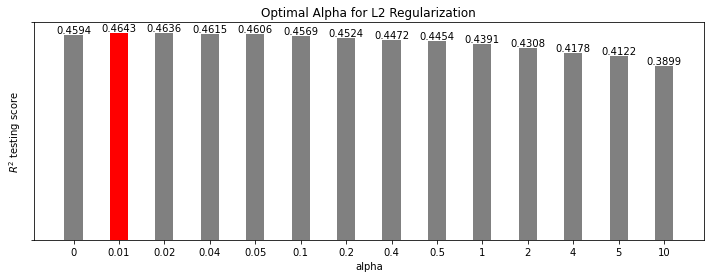

In [21]:
from sklearn.linear_model import Ridge

# find optimal alpha
def ridge_alpha(degree: int, alphas: list):
    # list of R2 testing scores
    R2_scores = []
    
    # calculate scores for each alpha value in list
    for alpha in alphas:
        ridge_reg = Pipeline(steps=[('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                                    ('ridge', Ridge(alpha=alpha, solver='auto'))])
        ridge_reg.fit(X_train, y_train)
        
        # R2 scores
        R2_train = ridge_reg.score(X_train, y_train)
        R2_test = ridge_reg.score(X_test, y_test)
        R2_scores.append(ridge_reg.score(X_test, y_test))
        # number of coefficients greater then 1
        num_coeff_greater = np.sum(abs(ridge_reg.named_steps['ridge'].coef_) > 1.0)
        
        print('For Alpha = {:.2f}: \tNumber of |coeff| > 1.0 = {}, \tR2 Training = {:.6f}, R2 Testing = {:.6f}'
         .format(alpha, num_coeff_greater, R2_train, R2_test))
    
    # plot results
    plt.figure(figsize=(12, 4))
    # highlight optimal alpha bar
    colors = ['red' if (bar == max(R2_scores)) else 'grey' for bar in R2_scores]
    plt.bar(list(map(str, alphas)), R2_scores, width=.4, color=colors)
    
    # add labels
    for i in range(len(R2_scores)):
        plt.text(x=i, y=R2_scores[i], s=np.round(R2_scores[i], decimals=4), ha='center', va='bottom').set_color('black')

    plt.title('Optimal Alpha for L2 Regularization')
    ax = plt.gca()
    ax.set_xlabel('alpha')
    ax.set_ylabel('$R^2$ testing score')
    ax.set_yscale('symlog')
    ax.axes.yaxis.set_ticklabels([])
    plt.show()
    
alphas = [0, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10]
ridge_alpha(degree=2, alphas=alphas)

Scores are highest for <code>alpha</code> equal 0.01 meaning there is slight overfitting in the model (if any). If the scores were highest at 0.00, then there would be no overfitting in the model, and adding the penalty term to our slope would not be necessary. We are dealing then with basic regression (ordinary least squares). Every next higher value from list decreases the models efficiency causing the value of coefficient to tend towards zero. This leads to tradeoff of higher bias for lower variance.

We can increase the polynomial order for purpose to see what kind of results we will achieve.

For Alpha = 0.00: 	Number of |coeff| > 1.0 = 923, 	R2 Training = 0.740057, R2 Testing = -3345.719751
For Alpha = 0.01: 	Number of |coeff| > 1.0 = 535, 	R2 Training = 0.527133, R2 Testing = 0.462481
For Alpha = 0.02: 	Number of |coeff| > 1.0 = 451, 	R2 Training = 0.523670, R2 Testing = 0.464726
For Alpha = 0.04: 	Number of |coeff| > 1.0 = 361, 	R2 Training = 0.520593, R2 Testing = 0.465595
For Alpha = 0.05: 	Number of |coeff| > 1.0 = 340, 	R2 Training = 0.519661, R2 Testing = 0.465563
For Alpha = 0.10: 	Number of |coeff| > 1.0 = 252, 	R2 Training = 0.516860, R2 Testing = 0.464706
For Alpha = 0.20: 	Number of |coeff| > 1.0 = 174, 	R2 Training = 0.513949, R2 Testing = 0.462887
For Alpha = 0.40: 	Number of |coeff| > 1.0 = 101, 	R2 Training = 0.510313, R2 Testing = 0.459674
For Alpha = 0.50: 	Number of |coeff| > 1.0 = 88, 	R2 Training = 0.508838, R2 Testing = 0.458154
For Alpha = 1.00: 	Number of |coeff| > 1.0 = 45, 	R2 Training = 0.502810, R2 Testing = 0.451257
For Alpha = 2.00: 	Number of

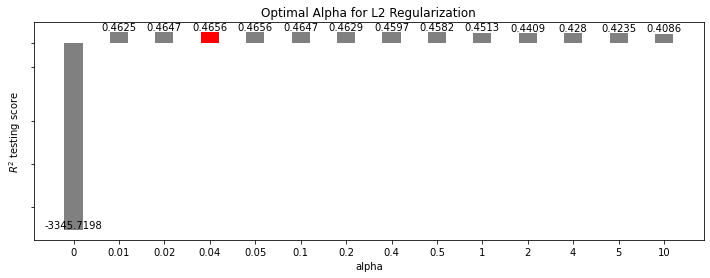

In [22]:
alphas = [0, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10]
ridge_alpha(degree=6, alphas=alphas)

In this case we especially increased the degree of freedom argument (and therefore overfitted it) in order to check the $R^2$ scores. We can immediately see this model (for this specifical order) is a bad predictor with a negative validation score, and adjusting it with regularization is vital.

To reduce overfitting in this model for a 6th order function, we need to apply penalty element with <code>alpha</code> equal 0.04. Next, we will develop a new regression model and evaluate its accuracy.

In [23]:
# perform ridge regression
def ridge_regression(degree: int, alpha: float):
    # fit model
    ridge_reg = Pipeline(steps=[('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                                ('ridge', Ridge(alpha=alpha, solver='auto'))])
    ridge_reg.fit(X_train, y_train)
    
    global rid_pred
    # predict rings
    rid_pred = ridge_reg.predict(X_test)
    
    # evaluate performance
    print('Number of Fitted Predictors:', ridge_reg.n_features_in_)
    print('Intercept:', ridge_reg.named_steps['ridge'].intercept_)
    print('Number of Coefficients:', ridge_reg.named_steps['ridge'].coef_.size)
    print('R2 Testing Score:', r2_score(y_test, rid_pred))
    print('Maximum Error:', max_error(y_test, rid_pred))
    print('RMSE:', mean_squared_error(y_test, rid_pred, squared=False))
    print('MAE:', mean_absolute_error(y_test, rid_pred))
    
ridge_regression(degree=6, alpha=0.04)

Number of Fitted Predictors: 6
Intercept: 2.3610631272769282
Number of Coefficients: 923
R2 Testing Score: 0.46559487709052794
Maximum Error: 10.728763519455924
RMSE: 2.2328586171608484
MAE: 1.6356721067839899


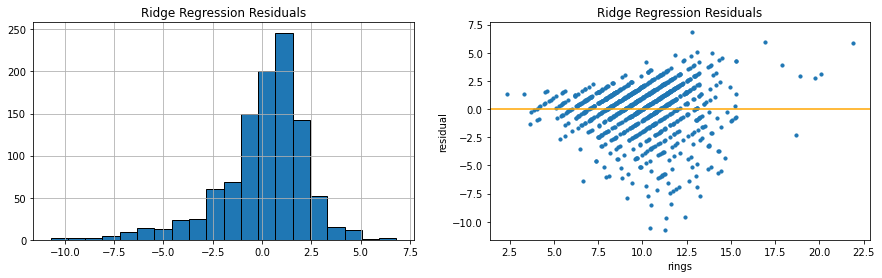

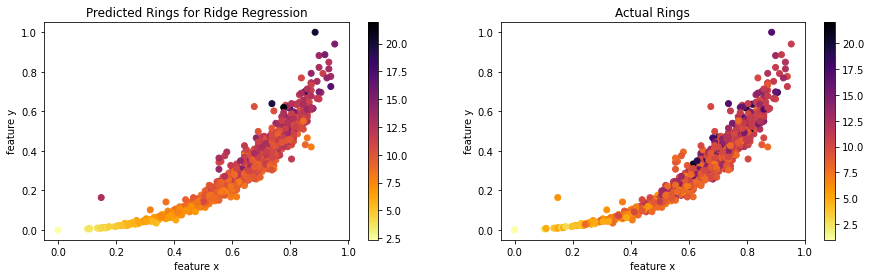

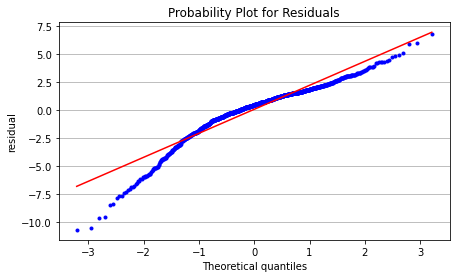

In [24]:
plot_residuals(pred_val=rid_pred, title='Ridge Regression')

Again, we trained a new estimating model with 6th order function and experimented its performance by adjusting the function's slope with L2 regularization with constant <code>alpha</code> equal 0.04. The evaluating scores improved and are even better then the metrics of 2nd degree model. The colorbar scale for estimated rings changed to a more appropriate interval. This time the model is more complex but also more accurate after applying penalty term and thus reducing the variance. Ridge regression decreases the complexity of a model but does not reduce the number of variables. Looking at the histogram the model seems to be more generalized.

We will proceed further and verify the models performance by implementing one more regularization operation.

#### 5c. LASSO Regression (L1 Regularization)

LASSO regression (acronym of: Least Absolute Shrinkage and Selection Operator) is similar to ridge regression and the idea is just the same. It flattens the slope of the regression line by adding a penalty term (L1 regularization) to the loss function during training allowing to avoid overfitting. The difference between these two methods is in the shrinkage penalty. In L2 regularization the tuning hyperparmeter $\alpha$ is multiplied by the squared sum of all coefficients, and in LASSO method the same factor is multiplied by the absolute value of all coefficients as below:

$$RSS + \alpha \centerdot \lvert slope\rvert = RSS + \alpha \sum_{j=1}^n \lvert \beta_j\rvert .$$

Unlike ridge regression, LASSO can reduce the slope to be exactly equal zero. Another interesting characteristic of LASSO regression's penalty is that it can shrink the coefficients of a model to zero, effectively reducing the number of features and simplifying the model. This method is useful if we have independent features that are useless. Less variables make the predicting model simpler and therefore less likely to be overfitted. However, increasing $\alpha$ too much for a given model, returns all coefficients equal zero meaning that literally none of the attributes are being used.

For Alpha = 0.00: 	Number of |coeff| > 1.0 = 26, 	R2 Training = 0.511880, R2 Testing = 0.463581
For Alpha = 0.01: 	Number of |coeff| > 1.0 = 4, 	R2 Training = 0.467193, R2 Testing = 0.412695
For Alpha = 0.02: 	Number of |coeff| > 1.0 = 2, 	R2 Training = 0.427193, R2 Testing = 0.369982
For Alpha = 0.04: 	Number of |coeff| > 1.0 = 2, 	R2 Training = 0.401157, R2 Testing = 0.347685
For Alpha = 0.05: 	Number of |coeff| > 1.0 = 2, 	R2 Training = 0.396714, R2 Testing = 0.346758
For Alpha = 0.10: 	Number of |coeff| > 1.0 = 2, 	R2 Training = 0.359687, R2 Testing = 0.325685
For Alpha = 0.20: 	Number of |coeff| > 1.0 = 1, 	R2 Training = 0.208070, R2 Testing = 0.193576
For Alpha = 0.40: 	Number of |coeff| > 1.0 = 0, 	R2 Training = 0.000000, R2 Testing = -0.000124
For Alpha = 0.50: 	Number of |coeff| > 1.0 = 0, 	R2 Training = 0.000000, R2 Testing = -0.000124
For Alpha = 1.00: 	Number of |coeff| > 1.0 = 0, 	R2 Training = 0.000000, R2 Testing = -0.000124
For Alpha = 2.00: 	Number of |coeff| > 1.0 = 0

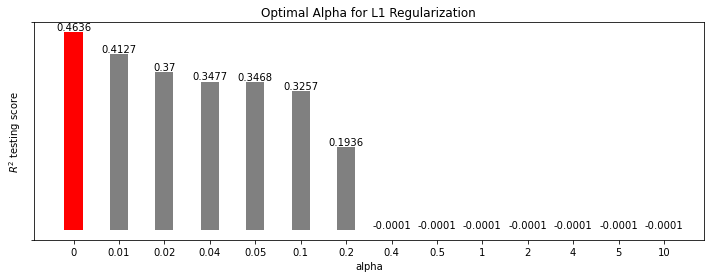

In [25]:
from sklearn.linear_model import Lasso

# find optimal alpha
def lasso_alpha(degree: int, alphas: list):
    # list of R2 testing scores
    R2_scores = []
    
    # calculate scores for each alpha value in list
    for alpha in alphas:
        lasso_reg = Pipeline(steps=[('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                                    ('lasso', Lasso(alpha=alpha, max_iter=10000))])
        lasso_reg.fit(X_train, y_train)
        
        # R2 scores
        R2_train = lasso_reg.score(X_train, y_train)
        R2_test = lasso_reg.score(X_test, y_test)
        R2_scores.append(lasso_reg.score(X_test, y_test))
        # number of coefficients greater then 1
        num_coeff_greater = np.sum(abs(lasso_reg.named_steps['lasso'].coef_) > 1.0)
        
        print('For Alpha = {:.2f}: \tNumber of |coeff| > 1.0 = {}, \tR2 Training = {:.6f}, R2 Testing = {:.6f}'
         .format(alpha, num_coeff_greater, R2_train, R2_test))
    
    # plot results
    plt.figure(figsize=(12, 4))
    # highlight optimal alpha bar
    colors = ['red' if (bar == max(R2_scores)) else 'grey' for bar in R2_scores]
    plt.bar(list(map(str, alphas)), R2_scores, width=.4, color=colors)
    
    # add labels
    for i in range(len(R2_scores)):
        plt.text(x=i, y=R2_scores[i], s=np.round(R2_scores[i], decimals=4), ha='center', va='bottom').set_color('black')
        
    plt.title('Optimal Alpha for L1 Regularization')
    ax = plt.gca()
    ax.set_xlabel('alpha')
    ax.set_ylabel('$R^2$ testing score')
    ax.set_yscale('symlog')
    ax.axes.yaxis.set_ticklabels([])
    plt.show()

alphas = [0, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10]
lasso_alpha(degree=2, alphas=alphas)

$R^2$ scores are highest for <code>alpha</code> equal 0.0, meaning the model is not too complex and there is no need of implementing shrinkage element to our function. The previous ridge regression detected very minimum overfitting in the model and LASSO method shouldn't also (or least very bit).

Implementing regularization terms with <code>alpha</code> greater or equal 0.20 shift the slope too much and fits the regressor very badly (with negative metrics). We can also notice how much LASSO regression simplified this model by increasing the number of coefficients.

For a next test, we will increase the function degree (make the model very complex) for purpose and examine results. We will then apply best $\alpha$ to polynomial regression.

For Alpha = 0.00: 	Number of |coeff| > 1.0 = 903, 	R2 Training = 0.547071, R2 Testing = 0.410836
For Alpha = 0.01: 	Number of |coeff| > 1.0 = 5, 	R2 Training = 0.473421, R2 Testing = 0.420073
For Alpha = 0.02: 	Number of |coeff| > 1.0 = 3, 	R2 Training = 0.441800, R2 Testing = 0.387369
For Alpha = 0.04: 	Number of |coeff| > 1.0 = 2, 	R2 Training = 0.401157, R2 Testing = 0.347685
For Alpha = 0.05: 	Number of |coeff| > 1.0 = 2, 	R2 Training = 0.396714, R2 Testing = 0.346758
For Alpha = 0.10: 	Number of |coeff| > 1.0 = 2, 	R2 Training = 0.359687, R2 Testing = 0.325685
For Alpha = 0.20: 	Number of |coeff| > 1.0 = 1, 	R2 Training = 0.208070, R2 Testing = 0.193576
For Alpha = 0.40: 	Number of |coeff| > 1.0 = 0, 	R2 Training = 0.000000, R2 Testing = -0.000124
For Alpha = 0.50: 	Number of |coeff| > 1.0 = 0, 	R2 Training = 0.000000, R2 Testing = -0.000124
For Alpha = 1.00: 	Number of |coeff| > 1.0 = 0, 	R2 Training = 0.000000, R2 Testing = -0.000124
For Alpha = 2.00: 	Number of |coeff| > 1.0 = 

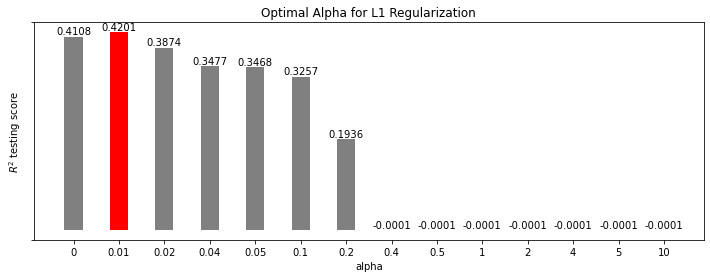

In [26]:
alphas = [0, 0.01, 0.02, 0.04, 0.05, 0.1, 0.2, 0.4, 0.5, 1, 2, 4, 5, 10]
lasso_alpha(degree=6, alphas=alphas)

In this case, we especially increased the degree of freedom argument (and therefore overfitted it) in order to check the coefficients of determination. To reduce overfitting in this model for a 6th order function, we need to apply L1 element with <code>alpha</code> equal 0.01. Next, we will develop a new regression model and evaluate its accuracy.

LASSO provides sparse solutions which is a great computational advantage as characteristics with zero coefficients can be simply ignored. In the case where we provided 6th order polynomial, we can immediately notice how much L1 regularization shrinked the quantity of unnecessary factors in this regression model and fixed overfitting. Only 5 out of 923 remained and the rest have been excluded.

In [27]:
# perform LASSO regression
def lasso_regression(degree: int, alpha: float):      
    # fit model
    lasso_reg = Pipeline(steps=[('poly', PolynomialFeatures(degree=degree, include_bias=False)),
                                ('lasso', Lasso(alpha=alpha, max_iter=10000))])
    lasso_reg.fit(X_train, y_train)
    
    global las_pred
    # predict rings
    las_pred = lasso_reg.predict(X_test)
    
    # evaluate performance
    print('Number of Fitted Predictors:', lasso_reg.n_features_in_)
    print('Intercept:', lasso_reg.named_steps['lasso'].intercept_)
    # number of coefficients for n-degree function
    print('Number of Coefficients:', lasso_reg.named_steps['lasso'].coef_.size)
    
    print('Number of Reduced Coefficients:', lasso_reg.named_steps['lasso'].coef_.size - 
          np.sum(lasso_reg.named_steps['lasso'].coef_ != 0))
    # number of coefficients not equal 0
    print('Number of Non-Zero Coefficients:', np.sum(lasso_reg.named_steps['lasso'].coef_ != 0))
    print('R2 Testing Score:', r2_score(y_test, las_pred))
    print('Maximum Error:', max_error(y_test, las_pred))
    print('RMSE:', mean_squared_error(y_test, las_pred, squared=False))
    print('MAE:', mean_absolute_error(y_test, las_pred))
    
lasso_regression(degree=6, alpha=0.01)

Number of Fitted Predictors: 6
Intercept: 5.218657772326167
Number of Coefficients: 923
Number of Reduced Coefficients: 918
Number of Non-Zero Coefficients: 5
R2 Testing Score: 0.4200728606220747
Maximum Error: 11.353220178228531
RMSE: 2.326015663969782
MAE: 1.7303007573131244


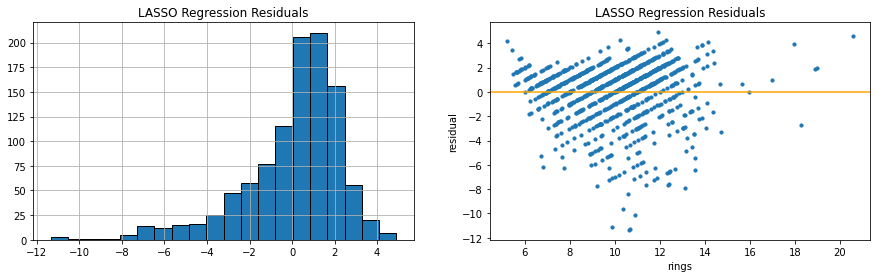

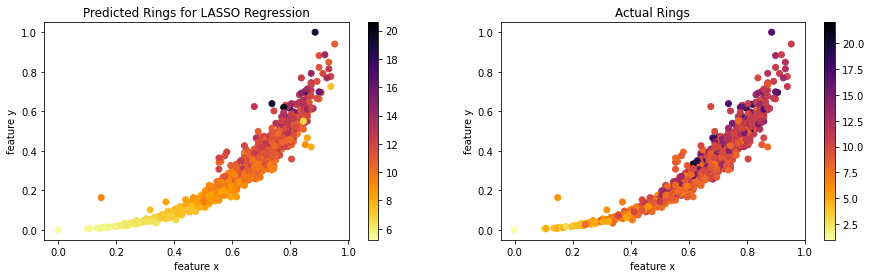

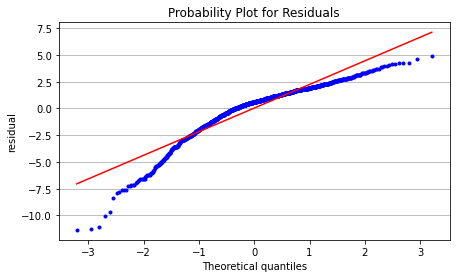

In [28]:
plot_residuals(pred_val=las_pred, title='LASSO Regression')

What brings attention is the fact that L1 penalization altered the loss function, thus increasing the quantity of positive residuals. This is most likely caused by the absolute value of all coefficients in its term. The skewness is still negative.

LASSO method altered significantly the colorbar scale for middle scatter plot. Overall looking at the markers colors, the predictions did not improve compared to ridge solution. The last plot also does not indicate any improvement in its distribution.

Other possibilities for finding optimum <code>alpha</code> values for regularization operations is to use the <code>GridSearchCV</code> or <code>KFold</code> modules, which apply cross validated grid search over a parameter grid. This feature selection technique works well with a small set of features but ridge and LASSO regression are great alternatives when we are dealing with a large set of features. If we want a balance between ridge and LASSO's penalty functions we can use <code>ElasticNet</code>. We will discuss this topic in detail in another repository.

Regularization operations are some of the simple techniques to reduce variance, balance model complexity and to prevent overfitting, which may result from simple linear regression. Ridge regression shrinks the coefficients to help reduce the model complexity and multi-collinearity, and LASSO regression reduces its number. A very general rule of thumb is that ridge regularization often produces slightly better predictions than LASSO, but the last one returns more interpretable models. Below are basic scores we used to evaluate all polynomial models:

| Regressor (Deg) | Standard (2nd) | Ridge (6th) | LASSO (6th) |
|-----------------|----------------|-------------|-------------|
| R2 Score        | 0.4594         | 0.4656      | 0.4201      |
| Max Error       | 10.8515        | 10.7289     | 11.3532     |
| RMSE            | 2.2457         | 2.2328      | 2.3260      |
| MAE             | 1.6292         | 1.6357      | 1.7303      |

Conclusions in a nutshell:
* ridge regression (L2 regularization) solves overfitting issues by adding a penalty term to the cost function (slope);
* LASSO regression (L1 regularization) provides solutions for reducing models complexity by adding its L1 reduction;
* the first trained model was a bit overfitted, but still was not too complex - applying LASSO term did not improve its performance and including its reduction is not valid.

### 6. Classification Model

Although <code>rings</code> column contains numerical values, we can also identify them as classes. They are integers and the classifier should accept them - this action for float types would not work.

The k-nearest neighbors (kNN) algorithm performs well with multi-label classes. This classifier is distance-based and has a feature similarity approach. It is a very simple, versatile and easy to understand machine learning algorithm. kNN also has a regression functionality. We will initialize the number of neighbors as 5 and start computing. We previously rescaled input variables and as a consequence shouldn't effect on the distance between data points.

#### k-Nearest Neighbors

In [29]:
from sklearn.neighbors import KNeighborsClassifier

# perform kNN classification
def knn_classification(k: int):
    if k <= 0:
        raise ValueError('K factor must be greater then 0')
    
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', algorithm='auto')
    # fit model
    knn.fit(X_train, y_train)
    
    global knn_pred
    # predict rings
    knn_pred = knn.predict(X_test)
      
    # display parameters
    print(knn.get_params())

knn_classification(k=5)

{'algorithm': 'auto', 'leaf_size': 30, 'metric': 'minkowski', 'metric_params': None, 'n_jobs': None, 'n_neighbors': 5, 'p': 2, 'weights': 'uniform'}


We built the classifier. Lets evaluate its performance. In this particular case we cannot plot a ROC curve (ROC and AUC support categorical data and the target should be binary). We can evaluate the accuracy of kNN classifier with a confusion matrix.

In [30]:
from sklearn.metrics import accuracy_score

# evaluate performance
def knn_classification_metrics():
    # missed classified samples
    print('Missed Classified Samples: {:.0f} Out of {:.0f}'.format((y_test != knn_pred).sum(), np.size(X_test, 0)))
    # accuracy scores
    print('Accuracy Score:', accuracy_score(y_test, knn_pred, normalize=True))
    # maximum error
    print('Maximum Error:', max_error(y_test, knn_pred))
    # mean error
    print('Mean Error:', np.mean(y_test != knn_pred))
    # root mean squared error
    print('RMSE:', mean_squared_error(y_test, knn_pred, squared=False))
    # mean absolute error
    print('MAE:', mean_absolute_error(y_test, knn_pred))
    
knn_classification_metrics()

Missed Classified Samples: 820 Out of 1045
Accuracy Score: 0.215311004784689
Maximum Error: 14
Mean Error: 0.784688995215311
RMSE: 2.7414940221864814
MAE: 1.877511961722488


In [31]:
from sklearn.metrics import classification_report

# display report
def print_classification_report():
    print(classification_report(y_test, knn_pred, digits=4))
    
print_classification_report()

              precision    recall  f1-score   support

           1     0.0000    0.0000    0.0000         1
           2     0.0000    0.0000    0.0000         1
           3     0.0000    0.0000    0.0000         2
           4     0.4444    0.2857    0.3478        14
           5     0.2121    0.3333    0.2593        21
           6     0.1786    0.2459    0.2069        61
           7     0.2033    0.2551    0.2262        98
           8     0.2812    0.2885    0.2848       156
           9     0.2259    0.3861    0.2850       158
          10     0.2138    0.1899    0.2012       179
          11     0.2458    0.2437    0.2447       119
          12     0.1143    0.0597    0.0784        67
          13     0.0000    0.0000    0.0000        47
          14     0.0000    0.0000    0.0000        35
          15     0.0000    0.0000    0.0000        26
          16     0.0000    0.0000    0.0000        17
          17     0.1667    0.0625    0.0909        16
          18     0.0000    

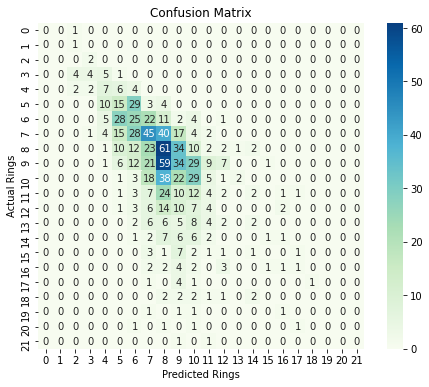

In [32]:
from sklearn.metrics import confusion_matrix

# plot error matrix
def plot_confusion_matrix(pred_val: np.array):
    plt.figure(figsize=(8, 6))
    heatmap(confusion_matrix(y_test, pred_val), cmap='GnBu', square=True, annot=True, fmt='d')
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Rings')
    plt.ylabel('Actual Rings')
    plt.show()

plot_confusion_matrix(knn_pred)

The biggest difficulty is to estimate ring values in range [7, 10]. Lets plot the obtained residuals.

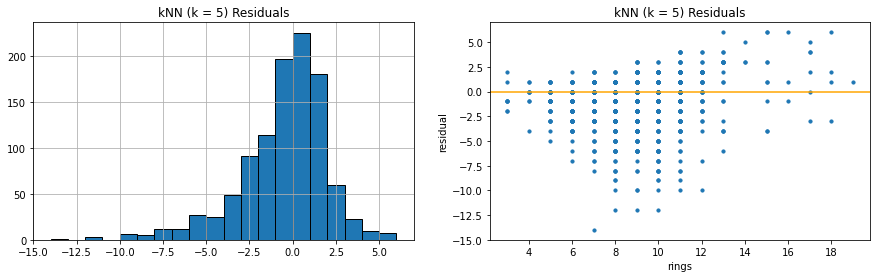

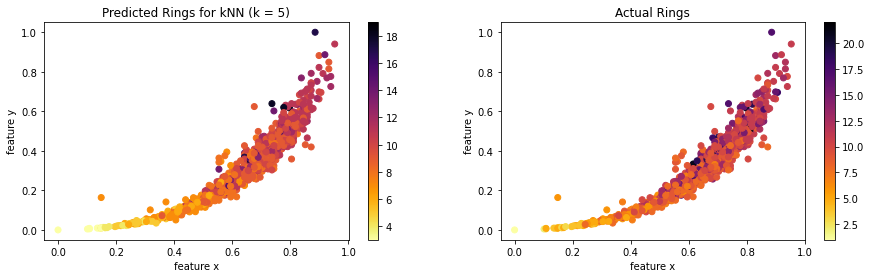

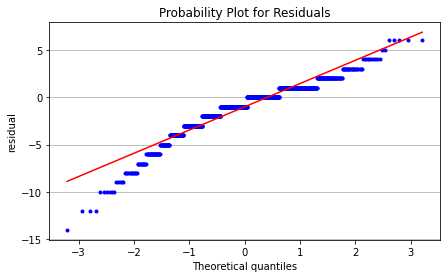

In [33]:
plot_residuals(pred_val=knn_pred, title='kNN (k = 5)')

First row plots present clear dominance of negative residuals. Not much labels have been estimated with zero value, although we need to keep in mind that the data points overlap each other. Since classification does not estimate continuous data, it is interesting to see integers (with grid distribution) on residual scatter plot.

The scatter plot representing predicted rings has a colorbar with narrower range than plot with actual values. At first glance the markers do not differ much.

The probability plot displays more negative skewness for obtained residuals. Their distribution is unbalanced and far from Gaussian.

### 7. Tuning and Optimizing the Classifier

Our classifying model has low performance, so we will try to improve it. The most important and core deciding hyperparameter in kNN classifier is the number of neighbors (or *k* value). The substantial *k* is better for classification as it leads to smoothening the decision boundaries. Unfortunately, there are no pre-defined statistical methods to find the most favorable value of *k*. We will derive a mean error plot, find the optimal value for this dataset, and train our model again with the suggested value. We can evaluate the kNN model for each value in range from 1 to 30 and extract the best result. The same operation can be repeated for accuracy ratings. Accuracy is the main metric for describing classification performance (unlike coefficient of determination or mean squared error for regression issues).

#### 7a. Finding the Best Number of Neighbors

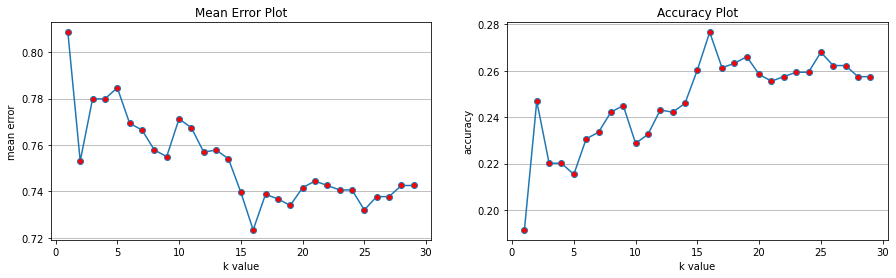

Minimum Error is For k = 16
Maximum Accuracy is For k = 16


In [34]:
# find optimal number of neighbors
def knn_rates():
    # lists of mean errors and accuracies
    mean_error = []
    accuracy = []
    
    # calculate metrics for k values between 1 and 30
    for k in range(1, 30):
        knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', algorithm='auto')
        knn.fit(X_train, y_train)
        pred_k = knn.predict(X_test)
        mean_error.append(np.mean(y_test != pred_k))
        accuracy.append(accuracy_score(y_test, pred_k, normalize=True))
        
    # visualize results
    fig = plt.figure(figsize=(15, 4))
    
    # subplot_1
    plt.subplot(1, 2, 1)
    plt.plot(range(1, 30), mean_error, marker='o', markerfacecolor='red', markersize=6)
    plt.title('Mean Error Plot')
    plt.xlabel('k value')
    plt.ylabel('mean error')
    plt.grid(axis='y')
    
    # subplot_2
    plt.subplot(1, 2, 2)
    plt.plot(range(1, 30), accuracy, marker='o', markerfacecolor='red', markersize=6)
    plt.title('Accuracy Plot')
    plt.xlabel('k value')
    plt.ylabel('accuracy')
    plt.grid(axis='y')
    plt.show()
    
    k1 = mean_error.index(min(mean_error)) + 1
    k2 = accuracy.index(max(accuracy)) + 1
    print('Minimum Error is For k =', k1)
    print('Maximum Accuracy is For k =', k2)
      
knn_rates()

If we look closely we can spot the plot lines are reflected horizontally. Adding accuracy to mean error returns 1.0. Using a mean error plot or accuracy plot is a fine method to find the most desirable *k* factor. Another way for upgrading supervised algorithms is using the <code>GridSearchCV</code> module over a parameter grid. We computed that we will get better efficiency for <code>n_neighbors</code> equal 16.

In [35]:
# perform kNN classification with new k-value
def tuned_knn_classification(k: int):
    if k <= 0:
        raise ValueError('k factor must be greater then 0')
    
    knn = KNeighborsClassifier(n_neighbors=k, metric='minkowski', algorithm='auto')
    # fit model
    knn.fit(X_train, y_train)
    
    global tknn_pred
    # predict rings
    tknn_pred = knn.predict(X_test)
    
    # evaluate performance
    print('Missed Classified Samples: {:.0f} Out of {:.0f}'.format((y_test != tknn_pred).sum(), np.size(X_test, 0)))
    print('Accuracy Score:', accuracy_score(y_test, tknn_pred, normalize=True))
    print('Maximum Error:', max_error(y_test, tknn_pred))
    print('Mean Error:', np.mean(y_test != tknn_pred))
    print('RMSE:', mean_squared_error(y_test, tknn_pred, squared=False))
    print('MAE:', mean_absolute_error(y_test, tknn_pred))

tuned_knn_classification(k=16)

Missed Classified Samples: 756 Out of 1045
Accuracy Score: 0.276555023923445
Maximum Error: 13
Mean Error: 0.723444976076555
RMSE: 2.6076809620810595
MAE: 1.6880382775119618


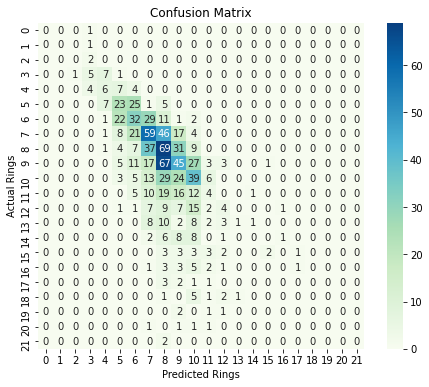

In [36]:
plot_confusion_matrix(tknn_pred)

This classifier still has difficulties to determine ring values for the most numerous population: in range from 7 to 10. The number of missed labels increased for this range, but overall the new model performed better. This dataset would probably need more characteristics that could describe and highlight marine snails that age. Let plot the residuals.

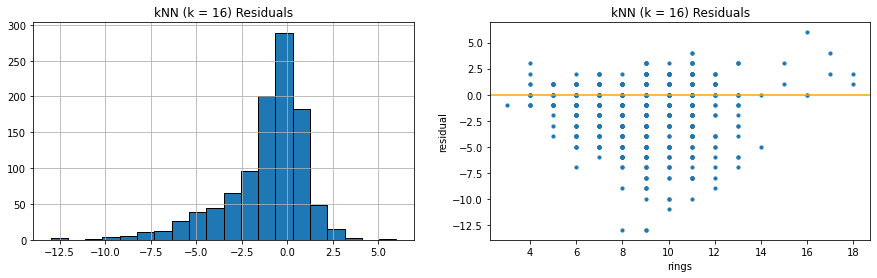

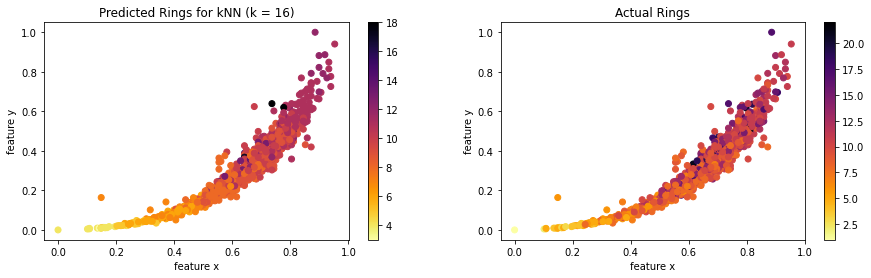

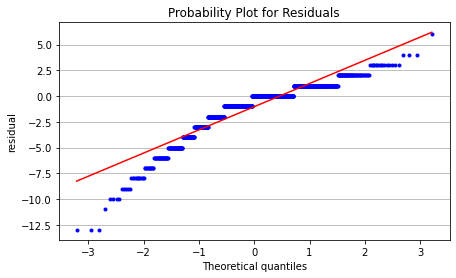

In [37]:
plot_residuals(pred_val=tknn_pred, title='kNN (k = 16)')

There is still negative skewness for new residuals. Negative residuals are more numerous then positive. The residual range decreased - previous graph displayed values equal almost -15.0.

The middle scatter plot representing estimated values shows a even more narrower colorbar range than the figure for *k* equal 5. Perhaps the higher number of neighbors narrowed the ring range and improved the models efficiency.

The residual distribution on the probability plot shifted a bit and is even more violated and uneven.

The overall model performance is better for *k* = 16 after comparing its metrics with the first one. A small value of neighbors isn’t always suitable for classification tasks. The number of missed samples also decreased and we obtained higher accuracy.

| kNN                  | k = 5  | k = 16 |
|----------------------|--------|--------|
| Missed Class Samples | 820    | 756    |
| Accuracy Score       | 0.2153 | 0.2766 |
| Max Error            | 14     | 13     |
| RMSE                 | 2.7415 | 2.6077 |
| MAE                  | 1.8775 | 1.6880 |

### 8. Summary

The subject of this notebook was to estimate the number of rings based on other independent features: either as a continuous value or as a classification problem. The task was completed successfully and we built our predictive models. With this dataset we are able to perform both regression and classification.

We developed two common used, supervised machine learning algorithms with <code>scikit-learn</code> library: polynomial regression and nearest neighbors. We also looked up for some techniques to tune up and improve their performance. The models indeed enhanced but their rates were still moderate.

It shouldn't come in surprise but this dataset is more suitable for regression tasks. The polynomial regressor had better evaluation in terms of RMSE and MAE. A misclassified label is a larger error than a decimal residual in regression problems. Predicting values based on statistical relationships was a better approach then on feature similarity. Perhaps the target data had too many classes to predict or the features were not very varied for this solution. We noticed on confusion matrices that the kNN algorithm had trouble predicting classes in the middle of the rings range.

**Further Development**<br>
The physical measurements should be repeated again. We noticed previously on box plots that this dataset has lots of outliers. Both polynomial regression and k-nearest neighbors are very sensitive to anomalies, which of course have impact on final results. We can also dive deeper and tune other arguments in our predicting models (for example: customizing distance for kNN, or selecting other variables for polynomial regression). There is a note the documentation, that further information, such as weather patterns and location (hence food availability) may be required to enrich the input data and improve solving the problem. Cooperating with a team of oceanologists, ecologists, and biologists could indeed help enhance predicting modeling for this dataset.